# Predict wavefield borders using the network combined with an FD solver

This notebook tests the NN's ability to continually predict wavefield borders during a simulation.

**Install necessary versions of packages**

In [ ]:
# Install packages if not available yet
!pip install git+https://github.com/devitocodes/devito.git --quiet
!pip install sympy==1.7.0 --quiet
!pip install numpy==1.17.0 --quiet

     |████████████████████████████████| 81kB 2.8MB/s 
     |████████████████████████████████| 102kB 7.4MB/s 
     |████████████████████████████████| 143kB 32.5MB/s 
     |████████████████████████████████| 51kB 6.9MB/s 
     |████████████████████████████████| 194kB 50.3MB/s 
     |████████████████████████████████| 71kB 8.5MB/s 
     |████████████████████████████████| 51kB 7.0MB/s 
     |████████████████████████████████| 71kB 8.6MB/s 
ERROR: pytest-cov 2.12.1 has requirement coverage>=5.2.1, but you'll have coverage 3.7.1 which is incompatible.
ERROR: pytest-cov 2.12.1 has requirement pytest>=4.6, but you'll have pytest 3.6.4 which is incompatible.
     |████████████████████████████████| 5.9MB 3.0MB/s 
     |████████████████████████████████| 20.3MB 1.3MB/s 
ERROR: tensorflow 2.5.0 has requirement numpy~=1.19.2, but you'll have numpy 1.17.0 which is incompatible.
ERROR: kapre 0.3.5 has requirement numpy>=1.18.5, but you'll have numpy 1.17.0 which is incompatible.
ERROR: datascience 0.10.6

In [ ]:
!nvidia-smi

Fri Jun 18 16:11:02 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    23W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%cd /content/drive/My\ Drive/ML_Ultrasound_Project/UROPdata

/content/drive/My Drive/ML_Ultrasound_Project/UROPdata


In [ ]:
pip install -U fvcore --quiet

     |████████████████████████████████| 51kB 2.1MB/s 
     |████████████████████████████████| 645kB 5.4MB/s 


In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import copy

from collections import deque

import pprint
from mpl_toolkits.axes_grid1 import make_axes_locatable

import devito
from sympy import Symbol
from devito import Operator
from devito import Eq, solve
from devito import TimeFunction

import torch
from torch.autograd import Variable
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch import nn

from sklearn.preprocessing import MinMaxScaler
import cv2
from scipy import stats
from scipy.ndimage import gaussian_filter

from tqdm.notebook import tqdm

from networks.convlstm import RNN

from medical.plotting import plot_shotrecord, plot_velocity
from medical.source import ToneBurstSource, Receiver
from medical.source import TimeAxis
from medical.model import Model

from fvcore.nn import FlopCountAnalysis

**Global settings**

In [ ]:
src_index = 315      # From 0 to 512
num = 2500            # Simulation last number of time steps
model_type = 'skull'  # water, skull or full

if src_index > 448 or src_index <= 64:
  nearest_border = 'right'
if src_index > 64 and src_index <= 192:
  nearest_border = 'bottom'
if src_index > 192 and src_index <=320:
  nearest_border = 'left'
if src_index > 320 and src_index <= 448:
  nearest_border = 'top'

In [ ]:
def create_eliptic_array(n_sources, boundary_offset, dx, shape):
    a = (shape[1] / 2)
    b = (shape[0] / 2)

    pos = np.empty((2, n_sources), dtype=np.float32)
    angle = np.zeros((n_sources))
    for idx in range(n_sources):
        angle[idx] = ((idx) * 360.0 / n_sources) * 2 * np.pi / 360.0  # transducer angle
        pos[1, idx] = (a * np.cos(angle[idx]) + shape[1] / 2)  # spherical equation of ellipse
        pos[0, idx] = (b * np.sin(angle[idx]) + shape[0] / 2)  # spherical equation of ellipse

    pos[0, :] += boundary_offset[0]
    pos[1, :] += boundary_offset[1]
    pos *= dx
    # np.array((np.divide(grid[0] ** 2, major_ax ** 2) + np.divide(grid[1] ** 2, minor_ax ** 2)) < 1, dtype=np.float32)
    return pos

In [ ]:
class MidpointNormalize(mpl.colors.Normalize):
    def __init__(self, vmin, vmax, midpoint=0, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
        normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
        normalized_mid = 0.5
        x, y = [self.vmin, self.midpoint, self.vmax], [normalized_min, normalized_mid, normalized_max]
        return np.ma.masked_array(np.interp(value, x, y))

class ModMidpointNormalize(mpl.colors.Normalize):
    def __init__(self, vmin, vmax, midpoint=0, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
        normalized_max = 1 #min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
        normalized_mid = 0.5
        x, y = [self.vmin, self.midpoint, self.vmax], [normalized_min, normalized_mid, normalized_max]
        return np.ma.masked_array(np.interp(value, x, y))

class OnesMidpointNormalize(mpl.colors.Normalize):
    def __init__(self, vmin, vmax, midpoint=0, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        normalized_min = -1 #max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
        normalized_max = 1 #min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
        normalized_mid = 0.5
        x, y = [self.vmin, self.midpoint, self.vmax], [normalized_min, normalized_mid, normalized_max]
        return np.ma.masked_array(np.interp(value, x, y))

##Model Integration with Devito

In [ ]:
# Load trained RNN state dict

dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

numLayers = 3
numFeatures = 32

rnn = RNN(numLayers, numFeatures)
rnn.to(dev)
rnn.load_state_dict(torch.load('/content/drive/My Drive/ML_Ultrasound_Project/UROPdata/rnn46_state_dict_zeroed_225'))
rnn.eval()

RNN(
  (convlstm1): CLSTM_cell(
    (conv): Sequential(
      (0): Conv2d(33, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): GroupNorm(4, 128, eps=1e-05, affine=True)
    )
  )
  (convlstm2): CLSTM_cell(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): GroupNorm(4, 128, eps=1e-05, affine=True)
    )
  )
  (convlstm3): CLSTM_cell(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): GroupNorm(4, 128, eps=1e-05, affine=True)
    )
  )
  (reshape_output): ProcessOut(
    (tanh): Tanh()
    (flat): Flatten(start_dim=1, end_dim=-1)
    (linear): Linear(in_features=152352, out_features=11, bias=True)
  )
  (lambda_1): Lambda()
)

[[0.05801011 0.03945057]]


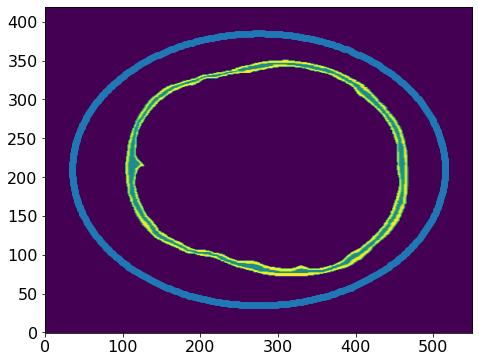

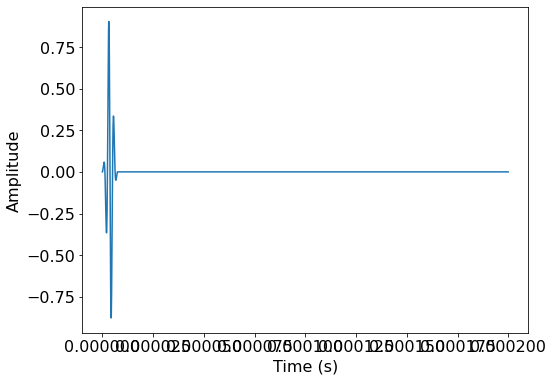

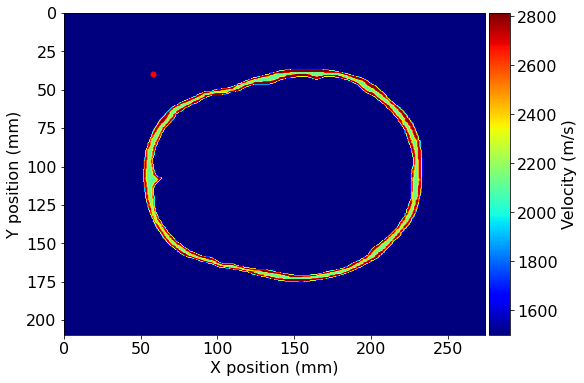

In [ ]:
devito.parameters.configuration['language'] = 'openmp'
devito.parameters.configuration['mpi'] = False

# By changing the src_index you'll be selecting a different source coordinate from the different 512 that have been created
# By changing the model type to water, skull or full you'll get different background mediums
# The cutting box has dimensions of (485, 355) in this case. This cannot change
# The cutting box is centred in the medium
# The complete medium is currently (1001, 1001) but you will have to make this bigger if you need to in order to
# make sure that the wavefield does not come back into the cutting box after hitting the edges of the complete medium

run_type = 'limited'  # infinite, limited

# Infinite will run the operator like when you generated your dataset. When you plot the resulting wavefield
# at the end, 'infinite' will look as if the wave is expanding into infinity. If you run it with 'limited'
# however, you'll see how the wave bounces back against the edge. The goal is to make the 'limited' case
# run as if it was the 'infinite' one by using your network.


# Load different types of background models
if model_type == 'water':
    model = np.ones((480, 350)) * 1500.

elif model_type == 'skull':
    model = np.fromfile('/content/drive/My Drive/ML_Ultrasound_Project/UROPdata/data/alpha2D-ExactSkull.raw', dtype=np.float32, count=-1)
    model = model.reshape([350, 480])[::1, ::1].transpose()

elif model_type == 'full':
    model = np.fromfile('/content/drive/My Drive/ML_Ultrasound_Project/UROPdata/data/alpha2D-TrueVp.raw', dtype=np.float32, count=-1)
    model = model.reshape([350, 480])[::1, ::1].transpose()

y_length = 480+66+4  #480+11
x_length = 350+66+4  #350+11

# Define a physical size
if run_type == 'infinite':
    shape = (1001, 1001)            # Number of grid point (nx, nz) - CHANGE THIS FOR THE MEDIUM SIZE
else:
    shape = (y_length, x_length)
    
spacing = (0.5e-3, 0.5e-3)      # Grid spacing in m.
origin = (0., 0.)               # What is the location of the top left corner. This is necessary to define
                                # the absolute location of the source and receivers

# Define a velocity profile. The velocity is in m/s
diff_x = shape[0] - model.shape[0]
diff_y = shape[1] - model.shape[1]
offset_x = int(np.floor(diff_x/2))
offset_y = int(np.floor(diff_y/2))

model = np.pad(model,
               ((int(np.floor(diff_x/2)), int(np.ceil(diff_x/2))), 
                (int(np.floor(diff_y/2)), int(np.ceil(diff_y/2)))),
               'edge')

plt.imshow(np.transpose(model), origin='lower')

# With the velocity and model size defined, we can create the seismic model that
# encapsulates this properties. We also define the size of the absorbing layer as 10 grid points
model = Model(vp=model, origin=origin, shape=shape, spacing=spacing, space_order=4, nbpml=0)

t0 = 0.                 # Simulation starts a t=0
dt = 0.08e-6            # Time step from model grid spacing

time_range = TimeAxis(start=t0, num=num, step=dt)

f0 = 0.40e6  # Source peak frequency is 400kHz
src = ToneBurstSource(name='src', grid=model.grid, f0=f0, npoint=1, time_range=time_range)

# First, position source centrally in all dimensions
src_positions = create_eliptic_array(512, (offset_x, offset_y), spacing[0], (480, 350))
src.coordinates.data[0, :] = src_positions[:, src_index]

print(src.coordinates.data)

plt.scatter(src_positions[0, :]/spacing[0], src_positions[1, :]/spacing[1])
plt.show()

# We can plot the time signature to see the wavelet
src.show()

# We can now show the source and receivers within our domain:
# Red dot: Source location
plot_velocity(model, source=src.coordinates.data)

In [ ]:
# In order to represent the wavefield u and the square slowness we need symbolic objects
# corresponding to time-space-varying field (u, TimeFunction) and
# space-varying field (m, Function)

# Define the wavefield with the size of the model and the time dimension
u = TimeFunction(name="u", grid=model.grid, time_order=2, space_order=4, save=num)

# Create a temporary symbol for H to avoid expensive sympy solve
H = Symbol('H')

# Define PDE
eq = model.m * u.dt2 - H

# Solve the symbolic equation for the field to be updated
eq_time = solve(eq, u.forward)

# Get the spacial FD
biharmonic = u.biharmonic(1/model.m)
laplacian = u.laplace + dt**2/12 * biharmonic

# This discrete PDE can be solved in a time-marching way updating u(t+dt) from the previous time step
# Devito as a shortcut for u(t+dt) which is u.forward. We can then rewrite the PDE as
# a time marching updating equation known as a stencil using customized SymPy functions
stencil = Eq(u.forward, eq_time.subs({H: laplacian}))

# Finally we define the source injection function to generate the corresponding code
src_term = src.inject(field=u.forward, expr=src * dt**2 / model.m)


In [ ]:
def execute_operator(kwargs, time_min=None, time_max=None):
    if time_min is None:
        time_min = 1

    if time_max is None:
        time_max = num-1

    kwargs['time_m'] = time_min
    kwargs['time_M'] = time_max
    
    args = op.arguments(**kwargs)

    arg_values = [args[p.name] for p in op.parameters]
    try:
        op.cfunction(*arg_values)

    except ctypes.ArgumentError as e:
        if e.args[0].startswith("argument "):
            argnum = int(e.args[0][9:].split(':')[0]) - 1
            newmsg = "error in argument '%s' with value '%s': %s" % (
                self._operator.parameters[argnum].name,
                arg_values[argnum],
                e.args[0])
            raise ctypes.ArgumentError(newmsg) from e
        else:
            raise
            
    op._postprocess_arguments(args, **kwargs)


In [ ]:
def get_network_inputs(w, y_len, x_len, top, right, bottom, left, t, norm):

  inputs = []

  # top row
  for i in range(y_len-22):
    square_timestep0_T = w[t-48][top][i:i+23, 11:34]
    square_timestep1_T = w[t-42][top][i:i+23, 11:34]
    square_timestep2_T = w[t-36][top][i:i+23, 11:34]
    square_timestep3_T = w[t-30][top][i:i+23, 11:34]
    square_timestep4_T = w[t-24][top][i:i+23, 11:34]
    square_timestep5_T = w[t-18][top][i:i+23, 11:34]
    square_timestep6_T = w[t-12][top][i:i+23, 11:34]
    square_timestep7_T = w[t-6][top][i:i+23, 11:34]
    square_timestep8_T = w[t][top][i:i+23, 11:34]

    #link the 5 images together
    inputs.append(np.stack((square_timestep0_T, square_timestep1_T, square_timestep2_T, square_timestep3_T, square_timestep4_T,
                                square_timestep5_T, square_timestep6_T, square_timestep7_T, square_timestep8_T), axis = 0))

  # right column
  for i in range(x_len-22):
    square_timestep0_T = np.rot90(w[t-48][right], 3)[i:i+23, 11:34]
    square_timestep1_T = np.rot90(w[t-42][right], 3)[i:i+23, 11:34]
    square_timestep2_T = np.rot90(w[t-36][right], 3)[i:i+23, 11:34]
    square_timestep3_T = np.rot90(w[t-30][right], 3)[i:i+23, 11:34]
    square_timestep4_T = np.rot90(w[t-24][right], 3)[i:i+23, 11:34]
    square_timestep5_T = np.rot90(w[t-18][right], 3)[i:i+23, 11:34]
    square_timestep6_T = np.rot90(w[t-12][right], 3)[i:i+23, 11:34]
    square_timestep7_T = np.rot90(w[t-6][right], 3)[i:i+23, 11:34]
    square_timestep8_T = np.rot90(w[t][right], 3)[i:i+23, 11:34]

    inputs.append(np.stack((square_timestep0_T, square_timestep1_T, square_timestep2_T, square_timestep3_T, square_timestep4_T,
                                square_timestep5_T, square_timestep6_T, square_timestep7_T, square_timestep8_T), axis = 0))

  # bottom row
  for i in range(y_len-22):
    square_timestep0_T = np.rot90(w[t-48][bottom], 2)[i:i+23, 11:34]
    square_timestep1_T = np.rot90(w[t-42][bottom], 2)[i:i+23, 11:34]
    square_timestep2_T = np.rot90(w[t-36][bottom], 2)[i:i+23, 11:34]
    square_timestep3_T = np.rot90(w[t-30][bottom], 2)[i:i+23, 11:34]
    square_timestep4_T = np.rot90(w[t-24][bottom], 2)[i:i+23, 11:34]
    square_timestep5_T = np.rot90(w[t-18][bottom], 2)[i:i+23, 11:34]
    square_timestep6_T = np.rot90(w[t-12][bottom], 2)[i:i+23, 11:34]
    square_timestep7_T = np.rot90(w[t-6][bottom], 2)[i:i+23, 11:34]
    square_timestep8_T = np.rot90(w[t][bottom], 2)[i:i+23, 11:34]

    inputs.append(np.stack((square_timestep0_T, square_timestep1_T, square_timestep2_T, square_timestep3_T, square_timestep4_T,
                                square_timestep5_T, square_timestep6_T, square_timestep7_T, square_timestep8_T), axis = 0))

  # left column
  for i in range(x_len-22):
    square_timestep0_T = np.rot90(w[t-48][left], 1)[i:i+23, 11:34]
    square_timestep1_T = np.rot90(w[t-42][left], 1)[i:i+23, 11:34]
    square_timestep2_T = np.rot90(w[t-36][left], 1)[i:i+23, 11:34]
    square_timestep3_T = np.rot90(w[t-30][left], 1)[i:i+23, 11:34]
    square_timestep4_T = np.rot90(w[t-24][left], 1)[i:i+23, 11:34]
    square_timestep5_T = np.rot90(w[t-18][left], 1)[i:i+23, 11:34]
    square_timestep6_T = np.rot90(w[t-12][left], 1)[i:i+23, 11:34]
    square_timestep7_T = np.rot90(w[t-6][left], 1)[i:i+23, 11:34]
    square_timestep8_T = np.rot90(w[t][left], 1)[i:i+23, 11:34]

    inputs.append(np.stack((square_timestep0_T, square_timestep1_T, square_timestep2_T, square_timestep3_T, square_timestep4_T,
                                square_timestep5_T, square_timestep6_T, square_timestep7_T, square_timestep8_T), axis = 0))

  return torch.from_numpy(np.asarray(inputs)/norm).cuda().view(-1, 9, 1, 23, 23)


In [ ]:
# Generator
class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

In [ ]:
def preprocess(x):
    return x.view(-1, 9, 1, 23, 23)#.to(dev)

In [ ]:
!nvidia-smi

Mon Jun 21 10:42:39 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    40W / 300W |   1363MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
top = (slice(0,None), slice(0,34))
right = (slice(-34,None), slice(0,None))
bottom = (slice(0,None), slice(-34,None))
left = (slice(0,34), slice(0,None))

norm = 3.005867554861652e-08

# Prepare the operator
u.data.fill(0.)
op = Operator([stencil] + src_term, subs=model.spacing_map)
    
kwargs = {'dt': dt}

shape = (1001, 1001) #(1001, 1001)            # Number of grid point (nx, nz) - CHANGE THIS FOR THE MEDIUM SIZE
size_diff = int((shape[0]-1001)/2)

# Execute the operator
for t in tqdm(range(1, num-2)):
  
  borders = get_network_inputs(np.asarray(u.data, dtype=np.float32), y_length, x_length, top, right, bottom, left, t+1, norm)

  with torch.no_grad():
    predictions = rnn(borders).cpu().detach()
    predictions *= norm

  execute_operator(kwargs, t, t+1)

  u.data[t+1][11:y_length-11,:11] = predictions[:y_length-22]
  u.data[t+1][-11:,11:x_length-11] = torch.rot90(predictions[y_length-22:y_length-22 + x_length-22], 1)
  u.data[t+1][11:y_length-11,-11:] = torch.rot90(predictions[y_length-22 + x_length-22:y_length-22 + x_length-22 + y_length-22], 2)
  u.data[t+1][:11,11:x_length-11] = torch.rot90(predictions[y_length-22 + x_length-22 + y_length-22:], 3)

  # Make corners zero
  u.data[t+1][:11,:11] = 0
  u.data[t+1][-11:,:11] = 0
  u.data[t+1][:11, -11:] = 0
  u.data[t+1][-11:, -11:] = 0

    # print('=========================================================================================================')
    # print('Timestep ',t)

    # plt.figure(figsize=(15,6))
    # plt.title('Wavefield with predicted borders')
    # plt.imshow(np.transpose(u.data[t+1][:,:]), cmap = 'seismic', norm=ModMidpointNormalize(vmin=np.max(v), vmax=np.min(v), midpoint=0))
    # plt.colorbar()
    # plt.show()


In [ ]:
borders = get_network_inputs(np.zeros((2500,y_length,x_length), dtype=np.float32), y_length, x_length, top, right, bottom, left, 50, norm)

In [ ]:
flops = FlopCountAnalysis(rnn, borders)
flops.total()
# flops.by_module_and_operator()

Unsupported operator aten::sigmoid encountered 81 time(s)
Unsupported operator aten::tanh encountered 55 time(s)
Unsupported operator aten::mul encountered 81 time(s)
Unsupported operator aten::add encountered 27 time(s)


109123795872

In [ ]:
np.savez_compressed('/content/drive/My Drive/ML_Ultrasound_Project/UROPdata/modelled_waves_3x32_{}'.format(src_index), u.data)

##Original 'Infinite' Devito Setup

[[0.17051011 0.18445057]]


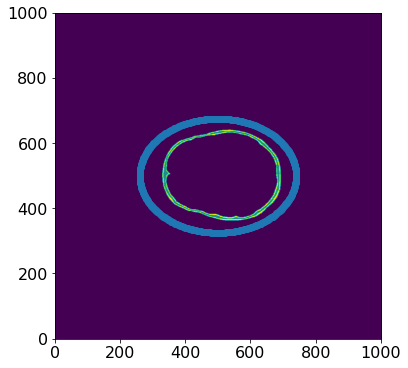

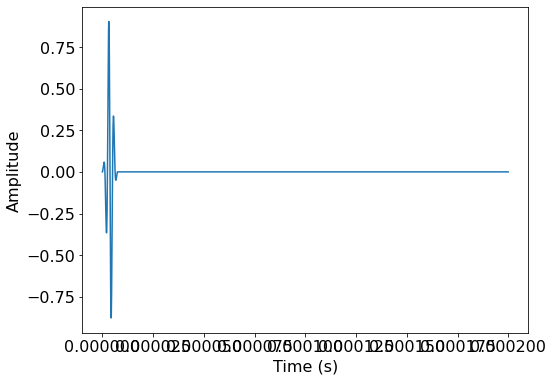

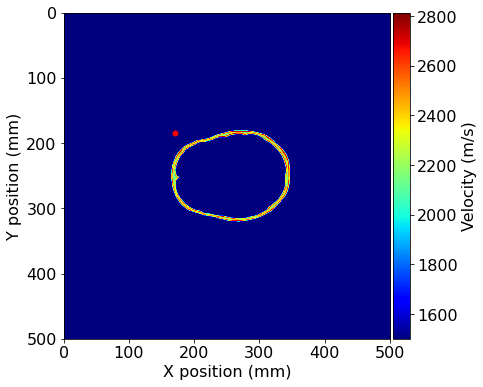

In [ ]:
devito.parameters.configuration['language'] = 'openmp'
devito.parameters.configuration['mpi'] = False

# By changing the src_index you'll be selecting a different source coordinate from the different 512 that have been created
# By changing the model type to water, skull or full you'll get different background mediums
# The cutting box has dimensions of (485, 355) in this case. This cannot change
# The cutting box is centred in the medium
# The complete medium is currently (1001, 1001) but you will have to make this bigger if you need to in order to
# make sure that the wavefield does not come back into the cutting box after hitting the edges of the complete medium

run_type = 'infinite'  # infinite, limited

# Infinite will run the operator like when you generated your dataset. When you plot the resulting wavefield
# at the end, 'infinite' will look as if the wave is expanding into infinity. If you run it with 'limited'
# however, you'll see how the wave bounces back against the edge. The goal is to make the 'limited' case
# run as if it was the 'infinite' one by using your network.

# Load different types of background models
if model_type == 'water':
    model = np.ones((480, 350)) * 1500.

elif model_type == 'skull':
    model = np.fromfile('/content/drive/My Drive/ML_Ultrasound_Project/UROPdata/data/alpha2D-ExactSkull.raw', dtype=np.float32, count=-1)
    model = model.reshape([350, 480])[::1, ::1].transpose()

elif model_type == 'full':
    model = np.fromfile('/content/drive/My Drive/ML_Ultrasound_Project/UROPdata/data/alpha2D-TrueVp.raw', dtype=np.float32, count=-1)
    model = model.reshape([350, 480])[::1, ::1].transpose()

y_length = 480+66+4  #480+11
x_length = 350+66+4  #350+11

# Define a physical size
if run_type == 'infinite':
    shape = (1001, 1001)            # Number of grid point (nx, nz) - CHANGE THIS FOR THE MEDIUM SIZE
else:
    shape = (y_length, x_length)
    
spacing = (0.5e-3, 0.5e-3)      # Grid spacing in m.
origin = (0., 0.)               # What is the location of the top left corner. This is necessary to define
                                # the absolute location of the source and receivers

# Define a velocity profile. The velocity is in m/s
diff_x = shape[0] - model.shape[0]
diff_y = shape[1] - model.shape[1]
offset_x = int(np.floor(diff_x/2))
offset_y = int(np.floor(diff_y/2))

model = np.pad(model,
               ((int(np.floor(diff_x/2)), int(np.ceil(diff_x/2))), 
                (int(np.floor(diff_y/2)), int(np.ceil(diff_y/2)))),
               'edge')

plt.imshow(np.transpose(model), origin='lower')

# With the velocity and model size defined, we can create the seismic model that
# encapsulates this properties. We also define the size of the absorbing layer as 10 grid points
model = Model(vp=model, origin=origin, shape=shape, spacing=spacing, space_order=4, nbpml=0)

t0 = 0.                 # Simulation starts a t=0
dt = 0.08e-6            # Time step from model grid spacing

time_range = TimeAxis(start=t0, num=num, step=dt)

f0 = 0.40e6  # Source peak frequency is 400kHz
src = ToneBurstSource(name='src', grid=model.grid, f0=f0, npoint=1, time_range=time_range)

# First, position source centrally in all dimensions
src_positions = create_eliptic_array(512, (offset_x, offset_y), spacing[0], (480, 350))
src.coordinates.data[0, :] = src_positions[:, src_index]

print(src.coordinates.data)

plt.scatter(src_positions[0, :]/spacing[0], src_positions[1, :]/spacing[1])
plt.show()

# We can plot the time signature to see the wavelet
src.show()

# We can now show the source and receivers within our domain:
# Red dot: Source location
plot_velocity(model, source=src.coordinates.data)

In [ ]:
# In order to represent the wavefield u and the square slowness we need symbolic objects
# corresponding to time-space-varying field (u, TimeFunction) and
# space-varying field (m, Function)

# Define the wavefield with the size of the model and the time dimension
u = TimeFunction(name="u", grid=model.grid, time_order=2, space_order=4, save=num)

# Create a temporary symbol for H to avoid expensive sympy solve
H = Symbol('H')

# Define PDE
eq = model.m * u.dt2 - H

# Solve the symbolic equation for the field to be updated
eq_time = solve(eq, u.forward)

# Get the spacial FD
biharmonic = u.biharmonic(1/model.m)
laplacian = u.laplace + dt**2/12 * biharmonic

# This discrete PDE can be solved in a time-marching way updating u(t+dt) from the previous time step
# Devito as a shortcut for u(t+dt) which is u.forward. We can then rewrite the PDE as
# a time marching updating equation known as a stencil using customized SymPy functions
stencil = Eq(u.forward, eq_time.subs({H: laplacian}))

# Finally we define the source injection function to generate the corresponding code
src_term = src.inject(field=u.forward, expr=src * dt**2 / model.m)


In [ ]:
def execute_operator(kwargs, time_min=None, time_max=None):
    if time_min is None:
        time_min = 1

    if time_max is None:
        time_max = num-1

    kwargs['time_m'] = time_min
    kwargs['time_M'] = time_max
    
    args = op.arguments(**kwargs)

    arg_values = [args[p.name] for p in op.parameters]
    try:
        op.cfunction(*arg_values)

    except ctypes.ArgumentError as e:
        if e.args[0].startswith("argument "):
            argnum = int(e.args[0][9:].split(':')[0]) - 1
            newmsg = "error in argument '%s' with value '%s': %s" % (
                self._operator.parameters[argnum].name,
                arg_values[argnum],
                e.args[0])
            raise ctypes.ArgumentError(newmsg) from e
        else:
            raise
            
    op._postprocess_arguments(args, **kwargs)


In [ ]:
# Prepare the operator
u.data.fill(0.)
op = Operator([stencil] + src_term, subs=model.spacing_map)
    
kwargs = {'dt': dt}

# Execute the operator
for t in tqdm(range(1, num-2)):
    
    execute_operator(kwargs, t, t+1)

    v = np.copy(u.data[t+1])

    # print('=========================================================================================================')
    # print('Timestep ',t)
    # plt.figure(figsize=(25,20))
    # plt.title('Left column images')
    # plt.yticks([11])
    # plt.imshow(np.rot90(v[275:726,275:325], 3))
    # plt.show()

    u.data[t+1] = v

In [ ]:
# Save middle
print(u.data.shape)
original_waves = []
inf_slices = (slice(225, -226), slice(290, -291))
for t in range(num):
    original_waves.append(u.data[t][inf_slices])
original_waves = np.array(original_waves)
print(original_waves.shape)

(2500, 1001, 1001)
(2500, 550, 420)


In [ ]:
np.savez_compressed('/content/drive/My Drive/ML_Ultrasound_Project/UROPdata/original_waves_{}'.format(src_index), original_waves)

##'Limited' Devito Setup

In [ ]:
devito.parameters.configuration['language'] = 'openmp'
devito.parameters.configuration['mpi'] = False

# By changing the src_index you'll be selecting a different source coordinate from the different 512 that have been created
# By changing the model type to water, skull or full you'll get different background mediums
# The cutting box has dimensions of (485, 355) in this case. This cannot change
# The cutting box is centred in the medium
# The complete medium is currently (1001, 1001) but you will have to make this bigger if you need to in order to
# make sure that the wavefield does not come back into the cutting box after hitting the edges of the complete medium

run_type = 'limited'  # infinite, limited

# Infinite will run the operator like when you generated your dataset. When you plot the resulting wavefield
# at the end, 'infinite' will look as if the wave is expanding into infinity. If you run it with 'limited'
# however, you'll see how the wave bounces back against the edge. The goal is to make the 'limited' case
# run as if it was the 'infinite' one by using your network.

# Load different types of background models
if model_type == 'water':
    model = np.ones((480, 350)) * 1500.

elif model_type == 'skull':
    model = np.fromfile('/content/drive/My Drive/ML_Ultrasound_Project/UROPdata/data/alpha2D-ExactSkull.raw', dtype=np.float32, count=-1)
    model = model.reshape([350, 480])[::1, ::1].transpose()

elif model_type == 'full':
    model = np.fromfile('/content/drive/My Drive/ML_Ultrasound_Project/UROPdata/data/alpha2D-TrueVp.raw', dtype=np.float32, count=-1)
    model = model.reshape([350, 480])[::1, ::1].transpose()

y_length = 480+66+4  #480+11
x_length = 350+66+4  #350+11

# Define a physical size
if run_type == 'infinite':
    shape = (1001, 1001)            # Number of grid point (nx, nz) - CHANGE THIS FOR THE MEDIUM SIZE
else:
    shape = (y_length, x_length)
    
spacing = (0.5e-3, 0.5e-3)      # Grid spacing in m.
origin = (0., 0.)               # What is the location of the top left corner. This is necessary to define
                                # the absolute location of the source and receivers

# Define a velocity profile. The velocity is in m/s
diff_x = shape[0] - model.shape[0]
diff_y = shape[1] - model.shape[1]
offset_x = int(np.floor(diff_x/2))
offset_y = int(np.floor(diff_y/2))

model = np.pad(model,
               ((int(np.floor(diff_x/2)), int(np.ceil(diff_x/2))), 
                (int(np.floor(diff_y/2)), int(np.ceil(diff_y/2)))),
               'edge')

plt.imshow(np.transpose(model), origin='lower')

# With the velocity and model size defined, we can create the seismic model that
# encapsulates this properties. We also define the size of the absorbing layer as 10 grid points
model = Model(vp=model, origin=origin, shape=shape, spacing=spacing, space_order=4, nbpml=0)

t0 = 0.                 # Simulation starts a t=0
dt = 0.08e-6            # Time step from model grid spacing

time_range = TimeAxis(start=t0, num=num, step=dt)

f0 = 0.40e6  # Source peak frequency is 400kHz
src = ToneBurstSource(name='src', grid=model.grid, f0=f0, npoint=1, time_range=time_range)

# First, position source centrally in all dimensions
src_positions = create_eliptic_array(512, (offset_x, offset_y), spacing[0], (480, 350))
src.coordinates.data[0, :] = src_positions[:, src_index]

print(src.coordinates.data)

plt.scatter(src_positions[0, :]/spacing[0], src_positions[1, :]/spacing[1])
plt.show()

# We can plot the time signature to see the wavelet
src.show()

# We can now show the source and receivers within our domain:
# Red dot: Source location
plot_velocity(model, source=src.coordinates.data)

In [ ]:
# In order to represent the wavefield u and the square slowness we need symbolic objects
# corresponding to time-space-varying field (u, TimeFunction) and
# space-varying field (m, Function)

# Define the wavefield with the size of the model and the time dimension
u = TimeFunction(name="u", grid=model.grid, time_order=2, space_order=4, save=num)

# Create a temporary symbol for H to avoid expensive sympy solve
H = Symbol('H')

# Define PDE
eq = model.m * u.dt2 - H

# Solve the symbolic equation for the field to be updated
eq_time = solve(eq, u.forward)

# Get the spacial FD
biharmonic = u.biharmonic(1/model.m)
laplacian = u.laplace + dt**2/12 * biharmonic

# This discrete PDE can be solved in a time-marching way updating u(t+dt) from the previous time step
# Devito as a shortcut for u(t+dt) which is u.forward. We can then rewrite the PDE as
# a time marching updating equation known as a stencil using customized SymPy functions
stencil = Eq(u.forward, eq_time.subs({H: laplacian}))

# Finally we define the source injection function to generate the corresponding code
src_term = src.inject(field=u.forward, expr=src * dt**2 / model.m)


In [ ]:
def execute_operator(kwargs, time_min=None, time_max=None):
    if time_min is None:
        time_min = 1

    if time_max is None:
        time_max = num-1

    kwargs['time_m'] = time_min
    kwargs['time_M'] = time_max
    
    args = op.arguments(**kwargs)

    arg_values = [args[p.name] for p in op.parameters]
    try:
        op.cfunction(*arg_values)

    except ctypes.ArgumentError as e:
        if e.args[0].startswith("argument "):
            argnum = int(e.args[0][9:].split(':')[0]) - 1
            newmsg = "error in argument '%s' with value '%s': %s" % (
                self._operator.parameters[argnum].name,
                arg_values[argnum],
                e.args[0])
            raise ctypes.ArgumentError(newmsg) from e
        else:
            raise
            
    op._postprocess_arguments(args, **kwargs)


In [ ]:
# Prepare the operator
u.data.fill(0.)
op = Operator([stencil] + src_term, subs=model.spacing_map)
    
kwargs = {'dt': dt}

# Execute the operator
for t in tqdm(range(1, num-2)):
    execute_operator(kwargs, t, t+1)

    v = np.copy(u.data[t+1])

    # print('=========================================================================================================')
    # print('Timestep ',t)
    # plt.figure(figsize=(25,20))
    # plt.title('Left column images')
    # plt.yticks([11])
    # plt.imshow(np.rot90(v[275:726,275:325], 3))
    # plt.show()

    u.data[t+1] = v

limited_waves = copy.deepcopy(u.data)

In [ ]:
np.savez_compressed('/content/drive/My Drive/ML_Ultrasound_Project/UROPdata/limited_waves', a=u.data)

In [ ]:
# # Plot the results, every 20 timesteps for now
# for t in range(0, num, 100):    
#     if run_type == 'infinite':
#         slices = (slice(255, -255), slice(320, -320))
#     else:
#         slices = (slice(0, None), slice(0, None))
    
#     plt.imshow(np.transpose(u.data[t][slices]))
#     plt.show()

##Compare solutions

In [ ]:
src_index = 315

original_waves = np.load('/content/drive/My Drive/ML_Ultrasound_Project/UROPdata/original_waves_{}.npz'.format(src_index))['arr_0']
# limited_waves = np.load('/content/drive/My Drive/ML_Ultrasound_Project/UROPdata/limited_waves.npz')['a']
modelled_waves = np.load('/content/drive/My Drive/ML_Ultrasound_Project/UROPdata/modelled_waves_3x32_{}.npz'.format(src_index))['arr_0']

In [ ]:
# inf_slices = (slice(255-35, -255-35), slice(320-35, -320-35))
inf_slices = (slice(225, -226), slice(290, -291))

In [ ]:
percentage_error = np.mean((original_waves-modelled_waves)*100/np.max(original_waves))

print('Average % error: {}'.format(percentage_error))

Average % error: -0.01338666770607233


In [ ]:
# Load different types of background models
model_type = 'skull'

if model_type == 'skull':
    model = np.fromfile('/content/drive/My Drive/ML_Ultrasound_Project/UROPdata/data/alpha2D-ExactSkull.raw', dtype=np.float32, count=-1)
    model = model.reshape([350, 480])[::1, ::1].transpose()

elif model_type == 'full':
    model = np.fromfile('/content/drive/My Drive/ML_Ultrasound_Project/UROPdata/data/alpha2D-TrueVp.raw', dtype=np.float32, count=-1)
    model = model.reshape([350, 480])[::1, ::1].transpose()

y_length = 480+66+4  #480+11
x_length = 350+66+4  #350+11

# Define a physical size
shape = (1001, 1001)            # Number of grid point (nx, nz) - CHANGE THIS FOR THE MEDIUM SIZE

    
spacing = (0.5e-3, 0.5e-3)      # Grid spacing in m.
origin = (0., 0.)               # What is the location of the top left corner. This is necessary to define
                                # the absolute location of the source and receivers

# Define a velocity profile. The velocity is in m/s
diff_x = shape[0] - model.shape[0]
diff_y = shape[1] - model.shape[1]
offset_x = int(np.floor(diff_x/2))
offset_y = int(np.floor(diff_y/2))

full_model = np.pad(model,
               ((int(np.floor(diff_x/2)), int(np.ceil(diff_x/2))), 
                (int(np.floor(diff_y/2)), int(np.ceil(diff_y/2)))),
               'edge')

In [ ]:
model = np.transpose(full_model[inf_slices])
# model[np.where(model == 1500)] = 0

# for src = 315, source coordinates are [78,116] -> flip to [116,78]
source= [116,78]
# for src = 128, sc = [515,211]
# source= [516,210]

In [ ]:
def nrmse_loss(y_pred, y_true):
    diff = np.divide(y_pred - y_true, np.max(y_true) - np.min(y_true) + 1e-6)
    return np.sqrt(np.mean(np.square(diff)))

**Plot and compare model vs infinite**

In [ ]:
skull_vmin = np.min(model)
skull_vmax = np.max(model)

skull_norm = ModMidpointNormalize(vmin=skull_vmin, vmax=skull_vmax, midpoint=1500)

cmap = 'seismic'
skull_cmap = 'RdGy'
err_cmap = 'Greys'

print('total nrmse: {}'.format(nrmse_loss(modelled_waves, original_waves)))

tp=0

fig, ax = plt.subplots(3,6, figsize=(30,30))

for t in range(200, 2500, 400):

  inf_img = np.transpose(original_waves[t])/np.max(np.abs(original_waves[t]))
  mod_img = np.transpose(modelled_waves[t])/np.max(np.abs(modelled_waves[t]))
  # inf_img = inf_img[11:-11, 11:-11]
  # mod_img = mod_img[11:-11, 11:-11]
  err_img = np.abs(np.divide((inf_img-mod_img)*100, np.max(np.abs(inf_img))))

  print('t: {}, nrmse: {}, max % error: {}'.format(t, nrmse_loss(mod_img, inf_img), np.max(err_img)))

  divider = make_axes_locatable(ax[0,tp])
  cax1 = divider.append_axes("right", size="5%", pad=0.05)
  ax[0,tp].set_title('Timestep {}'.format(t))
  ax[0,tp].set_yticks([])
  ax[0,tp].set_xticks([])
  im1 = ax[0,tp].imshow(inf_img, cmap=cmap, vmin=-1, vmax=1)
  ax[0,tp].scatter(source[0], source[1], s=25, c='red', marker='o')
  ax[0,tp].imshow(model, alpha=.2, cmap=skull_cmap, norm=skull_norm)
  cbar1 = fig.colorbar(im1, cax=cax1)
  cbar1.ax.set_ylabel('Pressure (AU)')

  divider = make_axes_locatable(ax[1,tp])
  cax2 = divider.append_axes("right", size="5%", pad=0.05)
  ax[1,tp].set_yticks([])
  ax[1,tp].set_xticks([])
  im2 = ax[1,tp].imshow(mod_img, cmap=cmap, vmin=-1, vmax=1)
  ax[1,tp].scatter(source[0], source[1], s=25, c='red', marker='o')
  ax[1,tp].imshow(model, alpha=.2, cmap=skull_cmap, norm=skull_norm)
  cbar2 = fig.colorbar(im2, cax=cax2)
  cbar2.ax.set_ylabel('Pressure (AU)')

  divider = make_axes_locatable(ax[2,tp])
  cax3 = divider.append_axes("right", size="5%", pad=0.05)
  ax[2,tp].set_yticks([])
  ax[2,tp].set_xticks([])
  im3 = ax[2,tp].imshow(err_img, cmap=err_cmap, vmin=0, vmax=6)
  ax[2,tp].scatter(source[0], source[1], s=25, c='red', marker='o')
  ax[2,tp].imshow(model, alpha=.2, cmap=skull_cmap, norm=skull_norm)
  cbar3 = fig.colorbar(im3, cax=cax3)
  cbar3.ax.set_ylabel('Percentage Error (%)')

  tp +=1

y = ax[0,0].set_ylabel('Infinite', fontsize=20, rotation=0, va="center")
ax[0,0].yaxis.set_label_coords(-0.3,0.5)

y = ax[1,0].set_ylabel('Network\nPredictions', fontsize=20, rotation=0, va="center")
ax[1,0].yaxis.set_label_coords(-0.3,0.5)

y = ax[2,0].set_ylabel('Errors', fontsize=20, rotation=0, va="center")
ax[2,0].yaxis.set_label_coords(-0.3,0.5)

fig.subplots_adjust(bottom=0.1, top=0.4, left=0.1, right=0.8,
                    wspace=0, hspace=0.1)

plt.show()

In [ ]:
# source= [116,78]

# skull_vmin = np.min(model)
# skull_vmax = np.max(model)

# skull_norm = ModMidpointNormalize(vmin=skull_vmin, vmax=skull_vmax, midpoint=1500)

# cmap = 'seismic'
# skull_cmap = 'RdGy'
# err_cmap = 'Greys'

# for t in range(1, num-2, 50):

#     inf_img = np.transpose(original_waves[t])/np.max(np.abs(original_waves[t]))
#     lim_img = np.transpose(limited_waves[t])/np.max(np.abs(limited_waves[t]))
#     mod_img = np.transpose(modelled_waves[t])/np.max(np.abs(modelled_waves[t]))
#     err_img = np.abs(np.divide((inf_img-mod_img)*100, np.max(np.abs(inf_img))))

#     print('============================================================================================================================================================================================================')
#     print('Timestep ',t)

#     # print(np.where(inf_img != 0))

#     fig, ax = plt.subplots(1,2, figsize=(18,9))
#     # fig, ax = plt.subplots(1,4, figsize=(30,20))

#     divider = make_axes_locatable(ax[0])
#     cax0 = divider.append_axes("right", size="5%", pad=0.05)
#     ax[0].set_title('Limited')
#     ax[0].set_yticks([])
#     ax[0].set_xticks([])
#     im0 = ax[0].imshow(lim_img, cmap=cmap, vmin=-1, vmax=1)
#     ax[0].scatter(source[0], source[1], s=25, c='red', marker='o')
#     ax[0].imshow(model, alpha=.2, cmap=skull_cmap, norm=skull_norm)
#     cbar0 = fig.colorbar(im0, cax=cax0)
#     cbar0.ax.set_ylabel('Pressure (AU)')

#     divider = make_axes_locatable(ax[1])
#     cax1 = divider.append_axes("right", size="5%", pad=0.05)
#     ax[1].set_title('Infinite')
#     ax[1].set_yticks([])
#     ax[1].set_xticks([])
#     im1 = ax[1].imshow(inf_img, cmap=cmap, vmin=-1, vmax=1)
#     ax[1].scatter(source[0], source[1], s=25, c='red', marker='o')
#     ax[1].imshow(model, alpha=.2, cmap=skull_cmap, norm=skull_norm)
#     cbar1 = fig.colorbar(im1, cax=cax1)
#     cbar1.ax.set_ylabel('Pressure (AU)')

# #     divider = make_axes_locatable(ax[2])
# #     cax2 = divider.append_axes("right", size="5%", pad=0.05)
# #     ax[2].set_title('Network Predictions')
# #     ax[2].set_yticks([])
# #     ax[2].set_xticks([])
# #     im2 = ax[2].imshow(mod_img, cmap=cmap, norm=mod_norm)
# #     ax[2].scatter(source[0], source[1], s=25, c='red', marker='o')
# #     ax[2].imshow(model, alpha=.2, cmap=skull_cmap, norm=skull_norm)
# #     cbar2 = fig.colorbar(im2, cax=cax2)
# #     cbar2.ax.set_ylabel('Pressure (AU)')

# #     divider = make_axes_locatable(ax[3])
# #     cax3 = divider.append_axes("right", size="5%", pad=0.05)
# #     ax[3].set_title('Errors: max error = {:.2f}%'.format(err_vmax))
# #     ax[3].set_yticks([])
# #     ax[3].set_xticks([])
# #     im3 = ax[3].imshow(err_img, cmap=err_cmap, vmin=0, vmax=err_vmax)
# #     ax[3].scatter(source[0], source[1], s=25, c='red', marker='o')
# #     ax[3].imshow(model, alpha=.2, cmap=skull_cmap, norm=skull_norm)
# #     cbar3 = fig.colorbar(im3, cax=cax3)
# #     cbar3.ax.set_ylabel('Percentage Error (%)')

#     plt.show()

**Save gifs**

In [ ]:
# for src = 315, source coordinates are [78,116] -> flip to [116,78]
source= [116,78]
# for src = 128, sc = [515,211]
# source= [516,210]

In [ ]:
skull_vmin = np.min(model)
skull_vmax = np.max(model)

skull_norm = ModMidpointNormalize(vmin=skull_vmin, vmax=skull_vmax, midpoint=1500)

cmap = 'seismic'
skull_cmap = 'RdGy'
err_cmap = 'Greys'

for t in tqdm(range(0, len(original_waves), 10)):

  inf_img = np.transpose(original_waves[t])/np.max(np.abs(original_waves[t]))
  mod_img = np.transpose(modelled_waves[t])/np.max(np.abs(modelled_waves[t]))
  # inf_img = inf_img[11:-11, 11:-11]
  # mod_img = mod_img[11:-11, 11:-11]
  err_img = np.abs(np.divide((inf_img-mod_img)*100, np.max(np.abs(inf_img))))

  plt.figure()
  plt.yticks([])
  plt.xticks([])
  im1 = plt.imshow(inf_img, cmap=cmap, vmin=-1, vmax=1)
  plt.scatter(source[0], source[1], s=25, c='red', marker='o')
  plt.imshow(model, alpha=.2, cmap=skull_cmap, norm=skull_norm)
  # plt.show()
  plt.savefig(str(t)+'_og_frames_src'+str(src_index)+'.png')
  plt.close()

  plt.figure()
  plt.yticks([])
  plt.xticks([])
  im1 = plt.imshow(mod_img, cmap=cmap, vmin=-1, vmax=1)
  plt.scatter(source[0], source[1], s=25, c='red', marker='o')
  plt.imshow(model, alpha=.2, cmap=skull_cmap, norm=skull_norm)
  # plt.show()
  plt.savefig(str(t)+'_mod_frames_src'+str(src_index)+'.png')
  plt.close()

  plt.figure()
  plt.yticks([])
  plt.xticks([])
  im1 = plt.imshow(err_img, cmap=err_cmap, vmin=0, vmax=6)
  plt.scatter(source[0], source[1], s=25, c='red', marker='o')
  plt.imshow(model, alpha=.2, cmap=skull_cmap, norm=skull_norm)
  # plt.show()
  plt.savefig(str(t)+'_err_frames_src'+str(src_index)+'.png')
  plt.close()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


In [ ]:
from PIL import Image

In [ ]:
og_fp_in = '_og_frames_src'+str(src_index)+'.png'
og_fp_out = 'og_'+str(src_index)+'.gif'

mod_fp_in = '_mod_frames_src'+str(src_index)+'.png'
mod_fp_out = 'mod_'+str(src_index)+'.gif'

err_fp_in = '_err_frames_src'+str(src_index)+'.png'
err_fp_out = 'err_'+str(src_index)+'.gif'

og_img, *og_imgs = [Image.open(str(f)+og_fp_in) for f in range(0,1500,10)]
og_img.save(fp=og_fp_out, format='GIF', append_images=og_imgs, save_all=True, duration=60, loop=0)

mod_img, *mod_imgs = [Image.open(str(f)+mod_fp_in) for f in range(0,1500,10)]
mod_img.save(fp=mod_fp_out, format='GIF', append_images=mod_imgs, save_all=True, duration=60, loop=0)

err_img, *err_imgs = [Image.open(str(f)+err_fp_in) for f in range(0,1500,10)]
err_img.save(fp=err_fp_out, format='GIF', append_images=err_imgs, save_all=True, duration=60, loop=0)